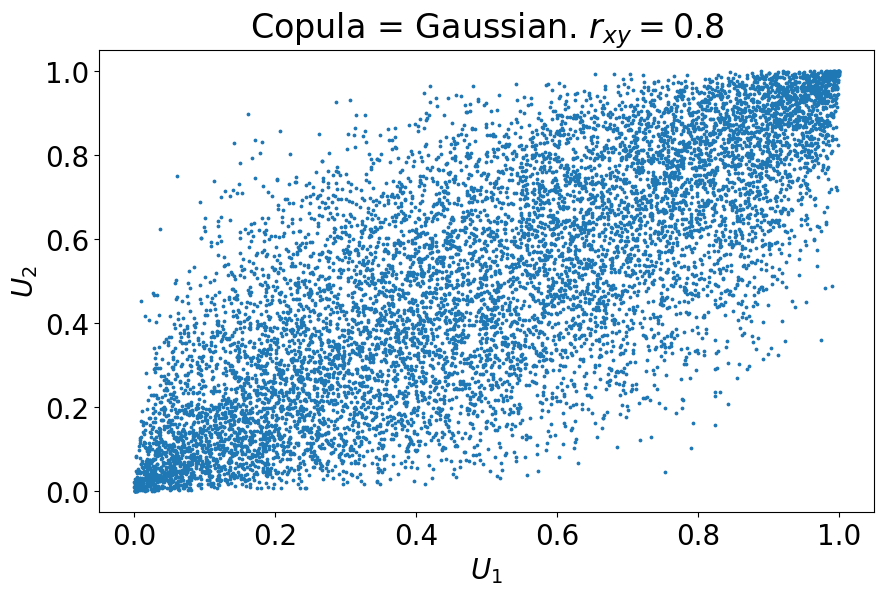

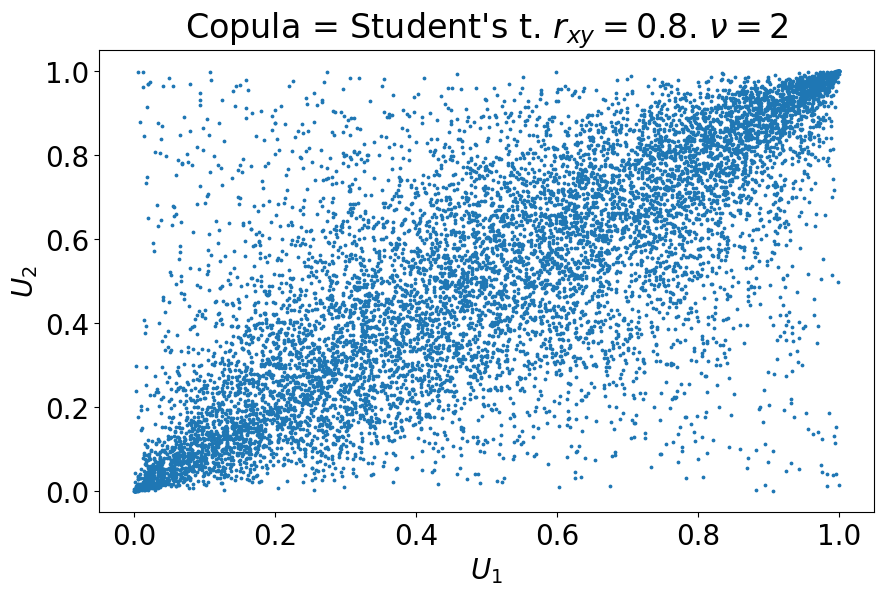

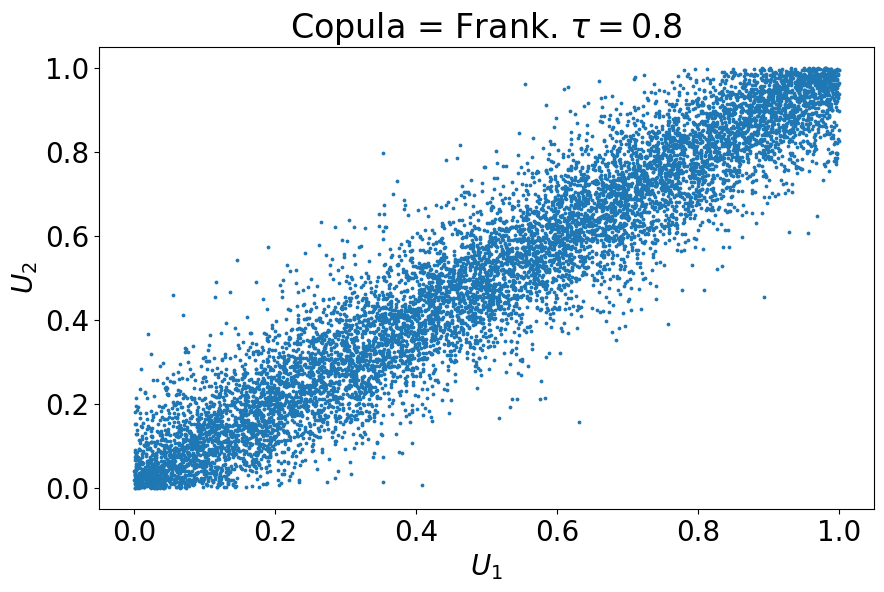

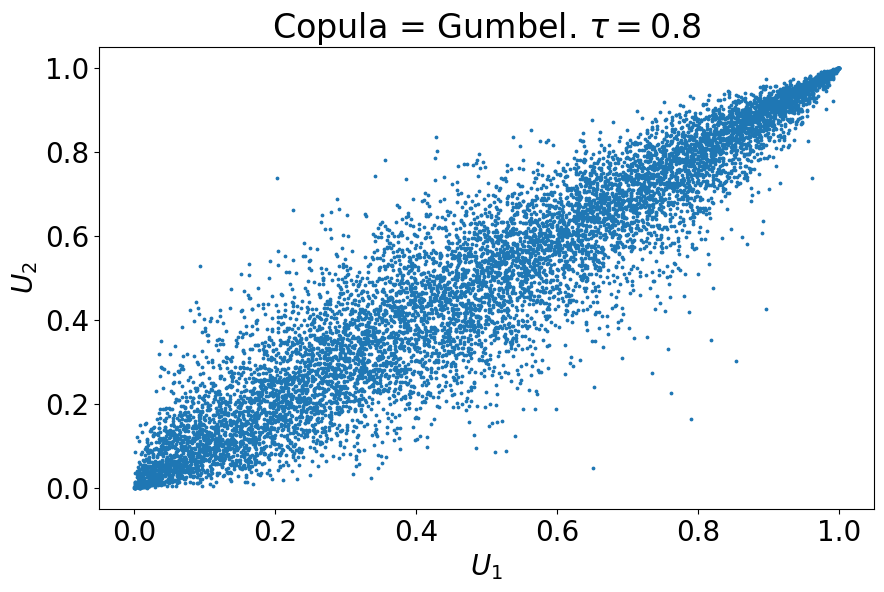

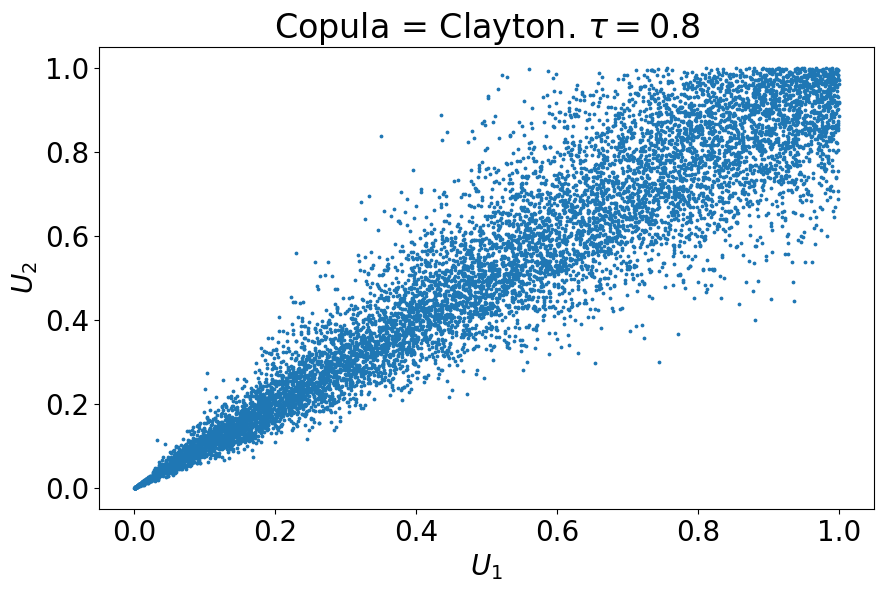

In [130]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, optimize
from statsmodels.distributions.copula.api import (ClaytonCopula, FrankCopula,
                                                  GaussianCopula, GumbelCopula,
                                                  StudentTCopula)

COPULAS_MAPPING = {
    "Gaussian": GaussianCopula,
    "Student's t": StudentTCopula,
    "Frank": FrankCopula,
    "Gumbel": GumbelCopula,
    "Clayton": ClaytonCopula,
}

# Generate random data
n_samples = 10000
tau = 0.8
corr = 0.8
df = 2


for copula_type, cop in COPULAS_MAPPING.items():
    if copula_type == "Gaussian":
        copula = cop(corr=corr)
    elif copula_type == "Student's t":
        copula = cop(corr=corr, df=df)
    elif copula_type == "Frank":

        ### How to calculate theta based on statsmodels source code ###
        def _debye(alpha):
            EPSILON = np.finfo(np.float32).eps

            def integrand(t):
                return t / (np.exp(t) - 1)

            debye_value = integrate.quad(integrand, EPSILON, alpha)[0] / alpha
            return debye_value
        
        def tau2(theta=None):
            # Joe 2014 p. 166
            debye_value = _debye(theta)
            return 1 + 4 * (debye_value - 1) / theta

        def theta_from_tau(_tau):
            MIN_FLOAT_LOG = np.log(sys.float_info.min)
            MAX_FLOAT_LOG = np.log(sys.float_info.max)

            def _theta_from_tau(alpha):
                return tau2(theta=alpha) - _tau

            result = optimize.least_squares(_theta_from_tau, 1, bounds=(
                MIN_FLOAT_LOG, MAX_FLOAT_LOG))
            theta = result.x[0]
            return theta
        
        ###############################################################

        theta = theta_from_tau(tau)
        copula = cop(theta=theta)
    elif copula_type == "Gumbel":
        theta = 1 / (1 - tau)
        copula = cop(theta=theta)
    elif copula_type == "Clayton":
        theta = 2 * tau / (1 - tau)
        copula = cop(theta=theta)

    # Generate random samples from the fitted copula
    samples = copula.rvs(n_samples)

    if copula_type == "Gaussian": 
        title = f"Copula = {copula_type}. $r_{{xy}} = {corr:.1f}$"
        savefile = f"{copula_type}_{corr}"
    elif copula_type == "Student's t":
        title = f"Copula = {copula_type}. $r_{{xy}} = {corr:.1f}$. $\\nu = {df:.0f}$"
        savefile = f"{copula_type}_{corr}_{df}"
    else: 
        title = f"Copula = {copula_type}. $\\tau = {tau:.1f}$"
        savefile = f"{copula_type}_{tau}"

    # Plot
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=3)
    plt.title(title)
    plt.xlabel(f"$U_{{1}}$")
    plt.ylabel(f"$U_{{2}}$")
    plt.savefig(f"CopulaPlots/{copula_type}-2", bbox_inches="tight")
    plt.show()